# OBJVAE

## Init

In [1]:
import os
import random, os
import numpy as np
import torch
import importlib
from objVAE import objVAE, MultiheadAttention


os.environ["CUDA_VISIBLE_DEVICES"] = "1"


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

### Helper functions

In [ ]:
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

image_size = 64

def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def run_test(model, combine_radius, plot_num=0, num_entities=10):
    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):
        gt_nodes = test_centroids[i_seq]

        # x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        x_hat, indices, pres, kl_divergence, xy, mu, logvar, attention = model(x)

        x = x.detach().cpu().numpy()
        x_hat = x_hat.detach().cpu().numpy()
        pres = pres.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(mu.shape[0]):
            xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()

            flatind = indices[i, :].detach().cpu().numpy()

            mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]

            xy = xy_mu[:, flatind]

            row, col = np.unravel_index(flatind, (16, 16))
            xp = (row + 0.5) * 4 - xy[0, :] * 2
            yp = (col + 0.5) * 4 - xy[1, :] * 2

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool)
                & matrix.astype(np.bool)
            ).astype(np.int32)

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(mu.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                    for ann in annotations:
                        ann.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(np.bool)],
                    xp[~remove_map_v[i].astype(np.bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                annotations = []
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    annotations.append(
                        plt.annotate(
                            round(pres[i, j], 3), (yp[j], xp[j]), color="white"
                        )
                    )
                plt.subplot(1, 2, 2)
                plt.imshow(x_hat[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i] * 1000
            yp_filtred = yp + remove_map_v[i] * 1000

            distances = distance_matrix(
                np.array([xp_filtred / image_size, yp_filtred / image_size]),
                gt_nodes_timestep,
            )
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                last_mapping = min_distance
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            tp = np.sum(gt_attention.astype(np.bool) & binary_attention.astype(np.bool))
            fp = np.sum(binary_attention.astype(np.bool)) - tp
            tn = np.sum(
                ~gt_attention.astype(np.bool) & ~binary_attention.astype(np.bool)
            )
            fn = np.sum(~binary_attention.astype(np.bool)) - tn

            mse_total.append(mse)
            false_detections_total.append(
                false_detections / (false_detections + true_detections)
            )
            missed_detections_total.append(missed_detections / (min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.argmax(binary_attention, axis=1)
                for i_prev, i_curr in enumerate(cols):
                    if remove_map_v[i - 1][i_prev] or remove_map_v[i][i_curr]:
                        continue
                    x_line = [xp_v[i - 1][i_prev], xp_v[i][i_curr]]
                    y_line = [yp_v[i - 1][i_prev], yp_v[i][i_curr]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean / (tp_mean + fp_mean)
    recall = tp_mean / (tp_mean + fn_mean)

    f1 = 2 * precision * recall / (precision + recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }
def update_position(previous_value, diffusion_constant, dt=1 / 10):
    new_position = np.clip(
        previous_value + np.random.randn(2) * np.sqrt(diffusion_constant * dt) * 1e7,
        0,
        image_size,
    )
    return new_position


def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions) / image_size


def generate_data(sequence_length, data_amount=1000):
    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6 / 2, 1e-6 * 2),
        z=lambda: np.random.uniform(-2, 2) * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    # %%
    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2, 6))
    image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    image_pipeline.update().plot()

    # generate a dataset of 1000 images
    print("Generating Training data")
    images = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)
        images.append(image_pipeline.update()())

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)
    print(tensors.shape)
    # make channel first
    tensors = tensors.permute(0, 1, 4, 2, 3)
    train_set, test_set = torch.utils.data.random_split(
        tensors, [int(data_amount * 0.8), int(data_amount * 0.2)]
    )

    print("Generating Test data")
    # generate a dataset of 1000 images
    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(int(data_amount * 0.1)):
        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)

            if i == len(images):
                break

            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)

        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return train_set, test_set, test, test_centroids, test_edges


def make_dataloaders(train_set, test_set, batch_size=16, num_workers=0):
    # create dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,  num_workers=num_workers)
    return train_loader, test_loader


def plot_training(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, indices, presence, kl_divergence, delta_xy_pred, mu, logvar, attention = model(x)
    recon, presence, xy,
    print(xy.shape, presence.shape)
    alpha = presence[0].detach().cpu().numpy() > 0.25
    xy = xy.detach().cpu().numpy()[0, alpha]

    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolor="r", facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    
    plt.subplot(2, 2, 3)
    plt.imshow(
        fg1[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 1")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        fg2[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 2")

    return plt

2023-09-25 12:00:21.005029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 12:00:22.521860: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

## Run/Test

### Generate data

Generating Training data
0
100
200
300
400
500
600
700
800
900
torch.Size([1000, 5, 64, 64, 1])
Generating Test data


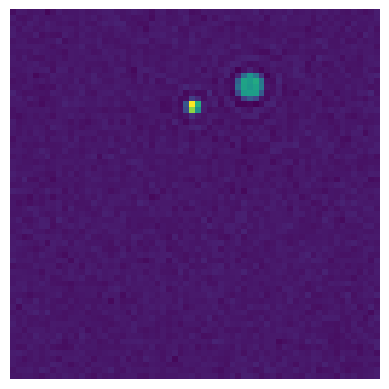

In [5]:
seqeunce_length = 5
data_amount = 1000
batch_size = 16

train_set, test_set, test, test_centroids, test_edges = generate_data(
    sequence_length=seqeunce_length,
    data_amount=data_amount,
)

In [ ]:
num_workers = 0

train_loader, test_loader = make_dataloaders(train_set, test_set, batch_size=batch_size, num_workers=num_workers)

### Create model

In [9]:
# Callbacks
max_steps = 20000
beta_annealing_end = 1800
lr_annealing_end = max_steps
kl_annealing_end = 2400
presence_annealing_end = 100


def beta_annealing(step):
    logs = np.logspace(-4, -2.5, beta_annealing_end)
    if step >= beta_annealing_end:
        return logs[-1]
    else:
        return logs[int(step)]


def presence_annealing(step):
    logs = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return logs[step]
    else:
        return 0


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        ipd.clear_output(wait=True)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [10]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

# load_model = "../state_dicts/model-5-500-spatial-non.pth"
# load_model = "../state_dicts/model-5-225-pres-glim32.pth"
load_model = ""

use_attention = True
num_entities = 10
softmax_tmp = 10
beta = beta = 1e-9
number_of_heads = 1


attention = MultiheadAttention.MultiheadAttention(
    max_t=1, softmax_factor=10, number_of_heads=1, num_filters=13
)
model = objVAE.MEVAE(
    10, attention_model=attention, beta=beta, attention=True, object_radius=16
)


if load_model:
    model.load_state_dict(torch.load(load_model))


### Train

In [11]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks()])
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                              | Params
------------------------------------------------------------
0 | model | MultiEntityVariationalAutoEncoder | 80.6 K
------------------------------------------------------------
80.6 K    Trainable params
0         Non-trainable params
80.6 K    Total params
0.322     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3488.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 34:  34%|███▍      | 17/50 [00:04<00:09,  3.42it/s, v_num=1141, loss_step=0.187, reconstruction_loss_step=0.186, KLD_step=0.0103, weighted_KLD_step=0.000717, loss_epoch=0.156, reconstruction_loss_epoch=0.155, KLD_epoch=0.00945, weighted_KLD_epoch=0.000598] 

### Test

/tmp/ipykernel_3731761/1432941003.py:131: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_3731761/1432941003.py:214: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp = np.sum(gt_attention.astype(np.bool) & bin

{'mae_mean': 0.011209601502913485, 'fd_mean': 0.7610833333333334, 'md_mean': 0.296875, 'precision': 0.14444444444444443, 'recall': 0.4287856071964018, 'f1-score': 0.21609369097091047}


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

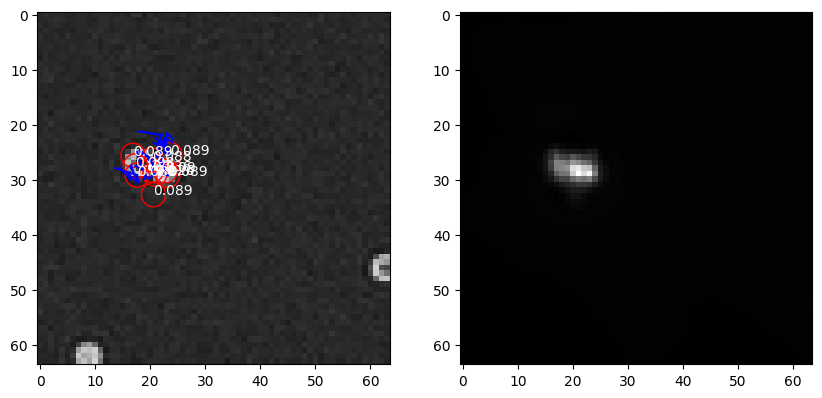

In [ ]:
metrics = run_test(model, 0.1, num_entities=10, plot_num=3)
print(metrics)

### Save model

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-5-20000-pres-glim32-an.pth")